# Nonlinear Elliptic problem: comparison between POD, PINN and POD-NN

Let us consider the two-dimensional spatial domain $\Omega = [0, 1]^2$. We want to solve the following parametrized problem: given $\mu = (\mu_0,\mu_1) \in P = [0.1,1]^2$, find $u(\mu)$ such that

$-\Delta u(\mu)+\frac{\mu_0}{\mu_1}(e^{\mu_1 u(\mu)}-1) = g(x;\mu)$,

with homogeneous Dirichlet boundary conditions and the source term defined as 

$g(x;\mu) = 100\sin(2\pi x_0)\cos(2\pi x_1) \ \ \ \forall x = (x_0,x_1) \in \Omega$.

In particular, we will solve the problem by means of POD-Galerkin method over a finite element full order model and then with a parametric PINN and a POD-NN algorithm. We want to compare the three approaches in terms of computational costs and accuracy with respect to the Full Order Model (FOM).

In order to check the accuracy of the FOM solution we compute also the High Fidelity solution of a Nonlinear Elliptic Problem of the same form as the one described above, but with the following exact solution
$$
    u_{ex}(x, \mu) = 16x_0x_1(1-x_0)(1-x_1).
$$
The relative right-hand-side is given by
$$
g = 32(x_0(1-x_0)+x_1(1-x_1)) + \frac{\mu_0}{\mu_1}\left(e^{16\mu_1 x_0x_1(1-x_0)(1-x_1)}-1\right).
$$
Solving this problem allows to verify if the High Fidelity solution satisfies the theoretical _a priori error estimation_. Indeed, if $u\in H^r(\Omega)$, with $r \leq k+1$ and $k$ order of the finite elements chosen, the Galerkin discretization error satisfies 
$$
||u-u_\delta||_{H^1(\Omega)} \leq C\delta^{(r-1)/2}|u|_{H^r(\Omega)}.
$$
In our particular case, $k = 1$ and $u_{ex}\in H^2(\Omega)$, so that we have the following error estimates
$$
||u-u_\delta||_{L^2(\Omega)} \leq C\delta|u|_{H^2(\Omega)}
$$
$$
||u-u_\delta||_{H_0^1(\Omega)} \leq C\delta^{1/2}|u|_{H^2(\Omega)}.
$$
It follows that the expected convergence orders in $L^2$-norm and $H_0^1$-norm are $c_0 = 1$ and $c_1 = 1/2$.

#### Import libraries

In [40]:
import sys
sys.path.append('/content/CppToPython')
import numpy as np
import GeDiM4Py as gedim
import math as mt
import time

#### Initialize

In [2]:
lib = gedim.ImportLibrary("/content/CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

In [3]:

def Progetto_a(numPoints, points):
	values_a = np.ones(numPoints, order='F')
	return values_a.ctypes.data

def Progetto_non_linear_b(numPoints, points, u, u_x, u_y):
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	values_nl_c = mu[0]*np.exp(mu[1]*vecu)
	return values_nl_c.ctypes.data

def Progetto_f(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values_f = 32.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) + matPoints[0,:] * (1.0 - matPoints[0,:])) + \
	mu[0]/mu[1]*(np.exp(mu[1]*16.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:])))-1)
	return values_f.ctypes.data

def Progetto_g(numPoints, points):
    matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
    values_g = 100.0 * np.sin(2 * np.pi * matPoints[0,:]) * np.cos(2 * np.pi * matPoints[1,:])
    return values_g.ctypes.data

def Progetto_non_linear_f(numPoints, points, u, u_x, u_y):
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	values_nl_f = mu[0]/mu[1]*(np.exp(mu[1]*vecu)-1)
	return values_nl_f.ctypes.data

def Progetto_non_linear_der_f(numPoints, points, u, u_x, u_y):
	vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
	vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
	values_nl_d_f = np.zeros((2, numPoints), order='F')
	values_nl_d_f[0,:] = vecu_x
	values_nl_d_f[1,:] = vecu_y
	return values_nl_d_f.ctypes.data

def Progetto_exactSolution(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values_ex = 16.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:]))
	return values_ex.ctypes.data

def Progetto_exactDerivativeSolution(direction, numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)

	if direction == 0:
		values_ex_d = 16.0 * (1.0 - 2.0 * matPoints[0,:]) * matPoints[1,:] * (1.0 - matPoints[1,:])
	elif direction == 1:
		values_ex_d = 16.0 * (1.0 - 2.0 * matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:])
	else:
		values_ex_d = np.zeros(numPoints, order='F')

	return values_ex_d.ctypes.data

def Ones(numPoints, points):
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data

def OnesDerivative(numPoints, points):
	values_one_d = np.ones((2, numPoints), order='F')
	return values_one_d.ctypes.data

def Zeros(numPoints, points):
	values_zero = np.zeros(numPoints, order='F')
	return values_zero.ctypes.data

def ZerosDerivative(direction, numPoints, points):
	values_zero_d = np.zeros(numPoints, order='F')
	return values_zero_d.ctypes.data

#### Definition of Geometry Parameters

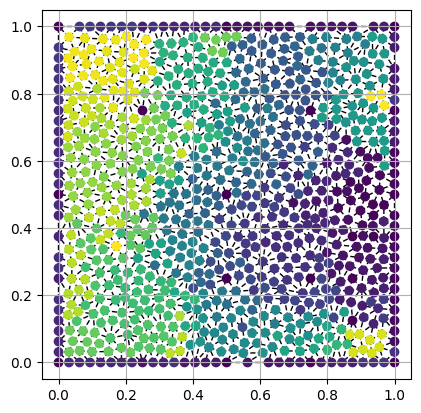

(3, 713)


In [4]:
meshSize = 0.001
order = 1

domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize }
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

gedim.PlotDofs(mesh,dofs,strongs)
print(dofs.shape)

# Full Order Model problem

The weak form of the problem we want to solve,
$$
\int_{\Omega}^{} \nabla u(\mu) \cdot \nabla v +  \int_{\Omega} \frac{\mu_0}{\mu_1} \left(e^{\mu_1 u(\mu)} - 1\right) v = \int_{\Omega} g(x;\mu)  v, \qquad \forall v \in V, \quad \forall \mu \in \mathcal{P}
$$
allows to write the problem like: find $u(\mu) \in V$ such that
$$
a(u(\mu),v; \mu) =F(v; \mu), \qquad \forall v \in V, \quad \forall \mu \in P
$$
where $a: V\times V \times P \rightarrow  \mathbb{R}$ and $F: V \times P \rightarrow  \mathbb{R}$.
Applying the Galerkin method the problem becomes: find $u_\delta(\mu) \in V_\delta$ such that
$$
a(u_\delta(\mu),v_\delta; \mu) =F(v_\delta; \mu), \qquad \forall v_\delta \in V_\delta, \quad \forall \mu \in \mathcal{P}.
$$
By defining a basis of $V_\delta$, we can write this problem in matrix form, thus getting the Full Order problem: find $u_\delta^\mu \in \mathbb{R}^{N_\delta}$ (High Fidelity solution) such that
$$
A^\mu u_\delta^\mu = f^\mu,
$$
with $A^\mu \in \mathbb{R}^{N_\delta\times N_\delta}$ and $f^\mu \in \mathbb{R}^{N_\delta}$.

## Newton Algorithm

The Full Order Model that we want to solve is nonlinear with respect to the solution $u_\delta(\mu)$, due to the presence of the second left-hand-side term of the weak formulation. Consequentially we linearize the problem by means of the Newton Method.

Newton schema consists in solving, for each $k$ iteration, the problem
$$
J_f [\partial u]_{|_{u_k}} = - f(u_k; v) = 0 \quad \forall v \in V
$$
where $J_f [\partial u]_{|_{u_k}}$ is the evaluation of the Jacobian of $f$ in the point $u_k$ along the unknown direction of $\partial u$.

After computations, we find the following linear problem, on each $k$ iteration: fixed $u_k$, find $\partial u$ s.t.

$$
 \int_\Omega \nabla\partial u\cdot\nabla v + \mu_0\int_\Omega e^{\mu_1 u_n}\partial u v = -\int_\Omega\nabla u_n\cdot\nabla v - \frac{\mu_0}{\mu_1} \int_\Omega (e^{\mu_1 u_n}-1)v + \int_\Omega gv.
$$

In [5]:
mu = [0.5, 0.1]

def compute_exact_FOM(mu, lib, problemData):
    # Newton parameters
    residual_norm = 1.0
    solution_norm = 1.0
    newton_tol = 1.0e-6
    max_iterations = 10
    num_iteration = 1
    
    u_k = np.zeros(problemData['NumberDOFs'], order='F')
    u_strong = np.zeros(problemData['NumberStrongs'], order='F')
    
    [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Progetto_a, problemData, lib)
    forcingTerm_g = gedim.AssembleForcingTerm(Progetto_f, problemData, lib)
    
    while num_iteration < max_iterations and residual_norm > newton_tol * solution_norm: 
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Progetto_a, Progetto_non_linear_b, u_k, u_strong, problemData, lib)
    
        forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Progetto_non_linear_f, u_k, u_strong, problemData, lib)
        forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Progetto_non_linear_der_f, u_k, u_strong, problemData, lib)
        
        du = gedim.LUSolver(stiffness + reaction, \
                forcingTerm_g - forcingTerm_v - forcingTerm_der_v, \
                lib)
        
        u_k = u_k + du
        
        du_normL2 = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)
        u_errorL2 = gedim.ComputeErrorL2(Progetto_exactSolution, u_k, u_strong, lib)
        u_errorH1 = gedim.ComputeErrorH1(Progetto_exactDerivativeSolution, u_k, u_strong, lib)
        u_normL2 = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib)
        u_normH1 = gedim.ComputeErrorH1(ZerosDerivative, u_k, u_strong, lib)
        
        solution_norm = u_normL2;
        residual_norm = du_normL2;
        
        #print("dofs", "h", "errorL2", "errorH1", "residual", "iteration", "max_iteration")
        #print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:.16e}'.format(u_errorL2 / u_normL2), '{:.16e}'.format(u_errorH1 / u_normH1), '{:.16e}'.format(residual_norm / u_normL2), '{:d}'.format(num_iteration), '{:d}'.format(max_iterations)) 
        
        num_iteration = num_iteration + 1

    return u_k, u_strong, u_errorL2/u_normL2, u_errorH1/u_normH1

In [6]:
[u_ex, u_strong, error_L2, error_H1] = compute_exact_FOM(mu, lib, problemData)

print("HIGH FIDELITY SOLUTION")
print("dofs", "h", "errorL2", "errorH1")
print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:.16e}'.format(error_L2), '{:.16e}'.format(error_H1))     

HIGH FIDELITY SOLUTION
dofs h errorL2 errorH1
713 6.4341029499729044e-02 2.6529949243323976e-03 5.1347302021095206e-02


### Plot High Fidelity solution

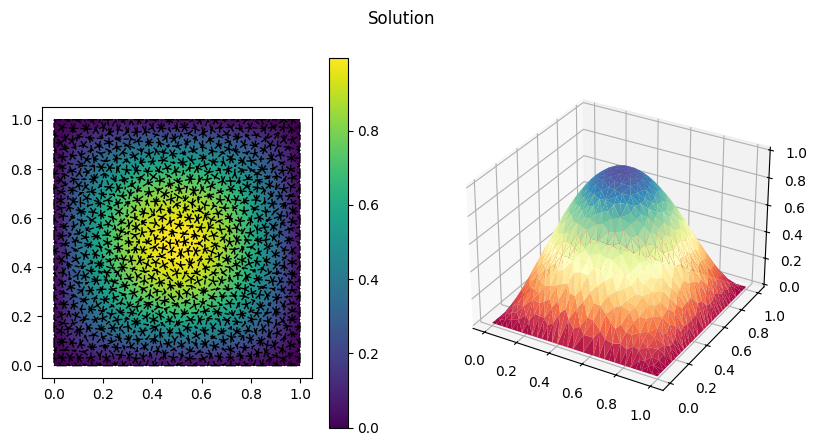

In [7]:
gedim.PlotSolution(mesh, dofs, strongs, u_ex, u_strong)
gedim.ExportSolution(Progetto_exactSolution, u_ex, u_strong, lib)

[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_ex, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib)

### Test on the convergence order

We want to verify that the Galerkin discretization error satisfies the error bounds given above.

In [8]:
meshSizes = [0.1, 0.01, 0.001]

error_L2 = []
error_H1 = []

for meshSize_test in meshSizes:
    domain_test = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize_test }
    [meshInfo_test, mesh_test] = gedim.CreateDomainSquare(domain_test, lib)
    discreteSpace_test = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] }
    [problemData_test, dofs_test, strongs_test] = gedim.Discretize(discreteSpace_test, lib)
    
    [u_exact, u_strong, err_L2, err_H1] = compute_exact_FOM(mu, lib, problemData_test)
    
    error_L2.append(err_L2)
    error_H1.append(err_H1)

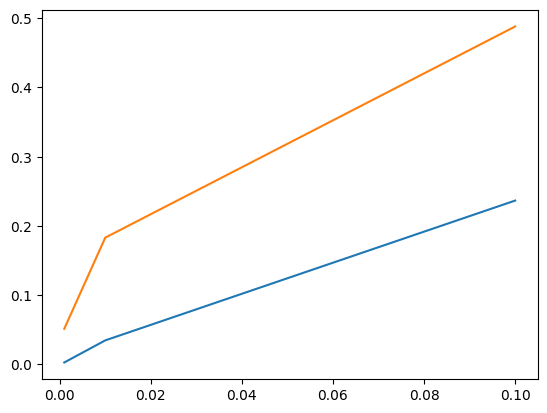

In [30]:
import matplotlib.pyplot as plt

plt.clf()
x = meshSizes
y = error_L2
plt.plot(x, y) 

y = error_H1
plt.plot(x, y) 


In [10]:
pol_L2 = np.polyfit(np.log(x), np.log(error_L2), 1)
pol_H1 = np.polyfit(np.log(x), np.log(error_H1), 1)
order_L2 = pol_L2[0]
order_H1 = pol_H1[0]
print("order_L2", "order_H1")
print(order_L2, order_H1)

order_L2 order_H1
0.9751241237932254 0.4890074628443306


In [11]:
# high fidelity solution with g

def compute_FOM(mu, lib, problemData):
    # Newton parameter
    newton_tol = 1.0e-6
    max_iterations = 10
    num_iteration = 1

    time_FOM = list()
    time_assembling_FOM = list()
    u_k = np.zeros(problemData['NumberDOFs'], order='F')    # full solution
    u_strong = np.zeros(problemData['NumberStrongs'], order='F')

    [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Progetto_a, problemData, lib)
    forcingTerm_g = gedim.AssembleForcingTerm(Progetto_g, problemData, lib)
    
    while num_iteration < max_iterations: 
        start_assembling_FOM = time.time()
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Progetto_a, Progetto_non_linear_b, u_k, u_strong, problemData, lib)
    
        forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, Progetto_non_linear_f, u_k, u_strong, problemData, lib)
        forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Progetto_non_linear_der_f, u_k, u_strong, problemData, lib)

        time_assembling_FOM.append(time.time() - start_assembling_FOM)
        
        # full solution computation timer
        start_compute_FOM = time.time()
        du = gedim.LUSolver(stiffness + reaction, \
                forcingTerm_g - forcingTerm_v - forcingTerm_der_v, \
                lib)
        
        u_k = u_k + du
        
        time_FOM.append(time.time() - start_compute_FOM)
        
        num_iteration = num_iteration + 1
        
    #total_assemble =  time_assembling_FOM + sum(time_assembling2_FOM)
    #total_compute_sol = sum(time_compute_FOM)
    #time_FOM = total_assemble + total_compute_sol
    
    return u_k, u_strong, time_FOM, time_assembling_FOM

### Plot High Fidelity solution

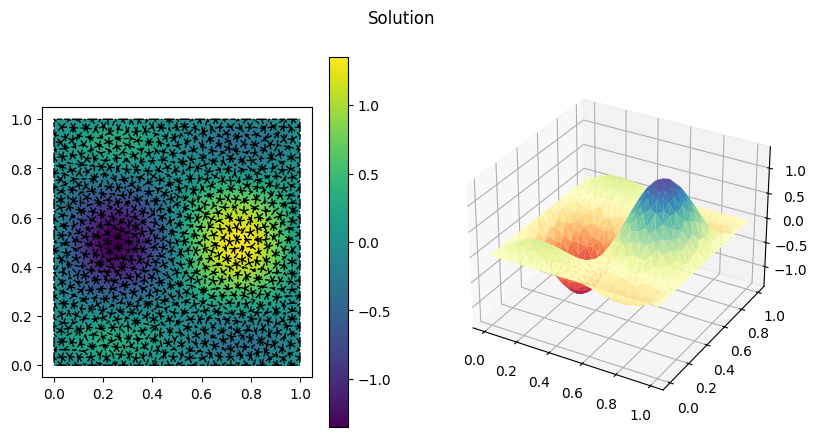

In [12]:
[u_k, u_strong, _, _] = compute_FOM(mu, lib, problemData)

gedim.PlotSolution(mesh, dofs, strongs, u_k, u_strong)
gedim.ExportSolution(Progetto_exactSolution, u_k, u_strong, lib)

[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib)

# POD

## Offline phase 

We here define the finite parametric space $\mathcal P_{train}$, with random uniform distributed realization of $\boldsymbol \mu$.
The cardinality of $\mathcal P_{train}$ is set to $M = 300$.

In [13]:
### define the training set

snapshot_num = 300 
mu0_range = [0.1, 1.]
mu1_range = [0.1, 1.]

np.random.seed(1)

P = np.array([mu0_range, mu1_range])

training_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(snapshot_num, P.shape[0]))

We now define the _snapshot matrix_. The snapshot matrix is $\mathbb U \in \mathbb R^{{M} \times {\mathcal N}}$, the matrix that contains by columns the high fidelity solutions of the problem related to a set of $M$ selected parameters.

In [14]:
#### snapshot matrix creation
snapshot_matrix = []

tol = 1. -1e-7
N_max = 10

for mu in training_set:
    [u_k_snap, u_strong_snap, _, _] = compute_FOM(mu, lib, problemData)
    
    snapshot = u_k_snap
    snapshot_matrix.append(np.copy(snapshot))
    
snapshot_matrix = np.array(snapshot_matrix) 


To build the $N$-dimesional framework we need, we define the covariance matrix $\mathbf C \in \mathbb R^{M \times M}$ and we solve the eigenvalue problem
$
    \mathbf C \omega_n = \lambda_n \omega_n
$ for $ 1 \leq n \leq M,$ with $\lvert \lvert {\omega_n}\rvert \rvert_{\mathbb V} = 1$. 
We can order the all-positive eigenvalues as $\lambda_1 >\dots > \lambda_{M}> 0$ and retain the first $N$ eigenpairs $(\lambda_n, \omega_n)$ for $1 \leq n \leq N$. 

$N$ is chosen looking at the eigenvalues. Indeed, defining as  $P_N: \mathbb V \rightarrow \mathbb V_N$ the projector from $\mathbb V$ onto $ {\mathbb V}_N$, $N$ is chosen such that the quantity:
\begin{equation}
    \sqrt{\frac{1}{M}
    \sum_{i = 1}^{M}  \lvert \lvert {u^{\mathcal N}(\boldsymbol{\mu}_{i}) - P_N(u^{\mathcal N}(\boldsymbol{\mu}_i))\rvert \rvert }_{2}^2} = \sqrt{
    \sum_{i = N + 1}^{M}\lambda_m.}
\end{equation}
remains below a fixed tolerance.

A fast decay of the eigenvalue magnitude guaratees a good representation $u^{N}$ of the high-fidelity solution with a few basis functions.

In [15]:
### covariance matrix
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Progetto_a, problemData, lib)
inner_product = stiffness

C = snapshot_matrix @ inner_product @ np.transpose(snapshot_matrix) 


L_e, VM_e = np.linalg.eig(C)
eigenvalues = []
eigenvectors = []

#### check

for i in range(len(L_e)):
  eig_real = L_e[i].real
  eig_complex = L_e[i].imag
  assert np.isclose(eig_complex, 0.)
  eigenvalues.append(eig_real)
  eigenvectors.append(VM_e[i].real)


total_energy = sum(eigenvalues)
retained_energy_vector = np.cumsum(eigenvalues)
relative_retained_energy = retained_energy_vector/total_energy


if all(flag==False for flag in relative_retained_energy>= tol):
  N = N_max
else:
  N = np.argmax(relative_retained_energy >= tol) + 1

print("The reduced dimension is", N)
#print(relative_retained_energy)

The reduced dimension is 3


We now have to create the basis matrix $\mathbb B$. In particular, we build the bases $\{\displaystyle \xi_i\}_{i=1}^N$ in the following way
$$    
\chi_i =  \sum_{m = 1}^{M} (\omega_i)_m u^{N}(\boldsymbol{\mu}_m),  \quad \quad 1 \leq i \leq N,
$$

and then $\displaystyle \xi_i = \frac{\chi_i}{\lvert \lvert \chi_i \rvert \rvert }_{\mathbb V}$.

In [16]:
# Create the basis function matrix
basis_functions = []
for n in range(N):
  eigenvector =  eigenvectors[n]
  
  basis = np.transpose(snapshot_matrix) @ eigenvector
  norm = np.sqrt(np.transpose(basis) @ inner_product @ basis) 
  
  basis /= norm
  basis_functions.append(np.copy(basis))

basis_functions = np.transpose(np.array(basis_functions))
print(f'Basis functions dimension: {basis_functions.shape}')

Basis functions dimension: (713, 3)


## Online phase

In the online phase we compute a new solution for a new parameter.

In [17]:
def compute_POD_solution(mu, lib, problemData):
    # Newton parameters
    newton_tol = 1.0e-6
    max_iterations = 10
    num_iteration = 1

    time_ROM = list()
    time_assembling_ROM = list()
    
    u_k_proj = np.zeros(problemData['NumberDOFs'], order='F') 
    u_strong_red = np.zeros(problemData['NumberStrongs'], order='F')
    u_k_red = np.zeros(N, order='F')
    [stiffness_red, stiffnessStrong_red] = gedim.AssembleStiffnessMatrix(Progetto_a, problemData, lib)
    reduced_stiffness = np.transpose(basis_functions) @ stiffness_red @ basis_functions
    
    forcingTerm_g_red = gedim.AssembleForcingTerm(Progetto_g, problemData, lib)
    reduced_g =  np.transpose(basis_functions) @ forcingTerm_g_red
    
    while num_iteration < max_iterations: 
        start_assembling = time.time()
        [reaction, reactionStrong_red] = gedim.AssembleNonLinearReactionMatrix(Progetto_a, Progetto_non_linear_b, u_k_proj, u_strong_red, problemData, lib)
        forcingTerm_v_red = gedim.AssembleNonLinearForcingTerm(Ones, Progetto_non_linear_f, u_k_proj, u_strong_red, problemData, lib)
        forcingTerm_der_v_red = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, Progetto_non_linear_der_f, u_k_proj, u_strong_red, problemData, lib)
    
        reduced_reaction = np.transpose(basis_functions) @ reaction @ basis_functions
        reduced_v =  np.transpose(basis_functions) @ forcingTerm_v_red
        reduced_der_v =  np.transpose(basis_functions) @ forcingTerm_der_v_red

        time_assembling_ROM.append(time.time() - start_assembling)
        # timer for reduced solution computation
        start_compute_ROM = time.time()
        
        du_red = gedim.LUSolver(reduced_stiffness + reduced_reaction, \
                reduced_g - reduced_v - reduced_der_v, \
                lib)
        u_k_red = u_k_red + du_red

        #Projection of reduced solution
        u_k_proj = basis_functions @ u_k_red
        time_ROM.append(time.time() - start_compute_ROM)
        du_proj = basis_functions @ du_red

        num_iteration = num_iteration + 1

    return u_k_proj, u_strong_red, time_ROM, time_assembling_ROM


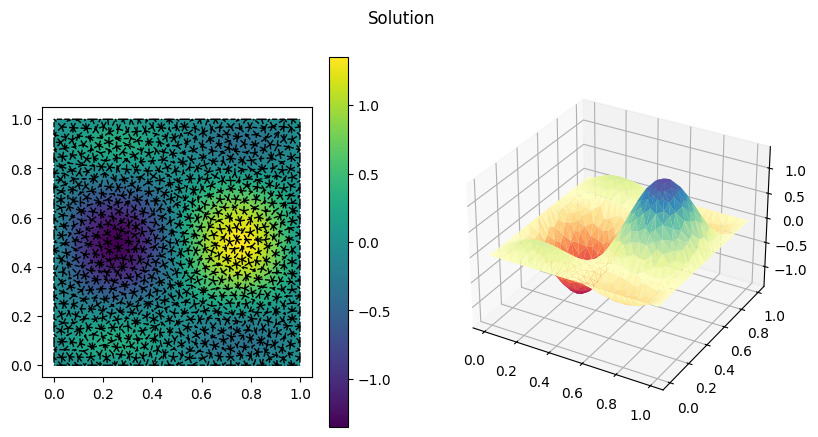

In [18]:
mu = [0.5, 0.1]
[u_k_proj, u_strong, _, _] = compute_POD_solution(mu, lib, problemData)

gedim.PlotSolution(mesh, dofs, strongs, u_k_proj, u_strong)

#gedim.ExportSolution(Progetto_exactSolution, u_k_proj, u_strong_red, lib)
#[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_k_proj, u_strong_red, lib)
#gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib)

We now perform an error analysis over the parametric space, together with a speed-up anaslysis.

The speed-up is an index that evaluated how many ROM solution I can obtain in the time of a FOM simulation.

In [19]:
### compute error

abs_err = []
abs_err_L2 = []
rel_err = []
rel_err_L2 = []
testing_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(20, P.shape[0]))
tot_speed_up = []

print("Computing error and speedup analysis")

for mu in testing_set:
    [u_k, u_strong, time_FOM, time_assembling_FOM] = compute_FOM(mu, lib, problemData)
    
    [u_k_proj, u_strong_red, time_ROM, time_assembling_ROM] = compute_POD_solution(mu, lib, problemData)

    tot_speed_up.append(sum(time_assembling_FOM+time_FOM)/sum(time_assembling_ROM+time_ROM))
    
    error_vector = u_k - u_k_proj
    absolute_error_L2 = np.linalg.norm(error_vector,2)
    error_norm_squared_comp = np.transpose(error_vector) @ inner_product @ error_vector
    absolute_error = np.sqrt(np.abs(error_norm_squared_comp))
    abs_err.append(absolute_error)
    abs_err_L2.append(absolute_error_L2)

    relative_error_L2 = absolute_error_L2/np.linalg.norm(u_k,2)
    full_solution_norm_squared_component = np.transpose(u_k) @  inner_product @ u_k
    relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
    rel_err.append(relative_error)
    rel_err_L2.append(relative_error_L2)

Computing error and speedup analysis


In [20]:
print(f'Average relative error: {np.mean(rel_err)}')
print(f'Average absolute error: {np.mean(abs_err)}')

print(f'Average relative L2 error: {np.mean(rel_err_L2)}')
print(f'Average absolute L2 error: {np.mean(abs_err_L2)}')

print(f'Average speed-up : {np.mean(tot_speed_up)}')

Average relative error: 3.0454667481133875e-05
Average absolute error: 0.00013970644637218782
Average relative L2 error: 2.0633587262446104e-05
Average absolute L2 error: 0.0002979132181513734
Average speed-up : 1.0555961714409723


# PINN

Physics Informed Neural Netwoks (PINN) relates deep learning and Partial Differential Equations (PDEs). 
The main idea is not to purely rely on data, but to exploit the physical model (i.e. the _residual_ of the PDE) in the loss function.

The loss function of a PINN is made by boundary and residual information.

Given a Neural Network $\tilde{w}(\mathbf x, \mathbf \mu)$ the loss will be of the form

$$
    MSE  \doteq MSE_b^{\mathbf \mu} + MSE_p^{\mathbf \mu}.
$$
where the boundary $MSE$ is
$$ 
        MSE_b \doteq \frac{1}{N_b} \sum_{k=1}^{N_b} | \tilde{w}(\mathbf x_k^b, \mathbf \mu_k^b) - u(\mathbf x_k^b, \mathbf \mu_k^b)|^2,
$$
for $(\mathbf x_k^b, \mathbf \mu_k^b) \in \partial \Omega \times \mathcal P$. While the physical $MSE$ (or _residual_) is
    $$
        MSE_{p} \doteq \frac{1}{N_p}\sum_{k=1}^{N_p}|\mathcal R(\tilde{w}(\mathbf x_k^p, \mathbf \mu_k^b))|^2.
    $$

for $(\mathbf x_k^b, \mathbf \mu_k^b) \in \Omega \times \mathcal P$.


In [21]:
import torch
import torch.nn as nn
from torch.autograd import Variable

seed = 35
np.random.seed(seed)
torch.manual_seed(seed)

Let us define the Neural Network.

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input_layer = nn.Linear(4,7) #input layer: n=4 inputs = x_0, x_1, mu_0, mu_1
        self.hidden_layer1 = nn.Linear(7,7) # we start with a single hidden layer: N_l = n + m + 2 = 7 from the UAT-2
        self.hidden_layer2 = nn.Linear(7,7)
        self.hidden_layer3 = nn.Linear(7,7)
        self.hidden_layer4 = nn.Linear(7,7)
        #self.hidden_layer5 = nn.Linear(7,7)
        self.output_layer = nn.Linear(7,1) # output layer: m=1: u is scalar

    def forward(self, x_0, x_1, mu_0, mu_1):
        input = torch.cat([x_0, x_1, mu_0, mu_1],axis=1)
        layer1_out = torch.sigmoid(self.input_layer(input)) #
        layer2_out = torch.sigmoid(self.hidden_layer1(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer2(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer3(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer4(layer4_out))
        #layer6_out = torch.sigmoid(self.hidden_layer5(layer5_out))
        output = self.output_layer(layer5_out)
        return output

In [23]:
torch.manual_seed(seed)
net = Net()
mse_cost_function = torch.nn.MSELoss() # Mean squared error
lr = 0.01
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [26]:
## PDE as loss function
def R(x_0,x_1,mu_0,mu_1,net):
    u = net(x_0,x_1,mu_0,mu_1) # the dependent variable u is given by the network based on independent variables x_0,x_1,mu_0,mu_1
    u_x0 = torch.autograd.grad(u.sum(), x_0, create_graph=True)[0]
    u_x0x0 = torch.autograd.grad(u_x0.sum(), x_0, create_graph=True)[0]

    u_x1 = torch.autograd.grad(u.sum(), x_1, create_graph=True)[0]
    u_x1x1 = torch.autograd.grad(u_x1.sum(), x_1, create_graph=True)[0]

    u_xx = u_x0x0 + u_x1x1
    
    g = torch.Tensor(100.0 * np.sin(2 * np.pi * x_0.detach().numpy()) * np.cos(2 * np.pi * x_1.detach().numpy()))

    pde = -u_xx + mu_0/mu_1*(torch.exp(mu_1*u)-1) - g
    return pde

In [27]:
dim = 600
x0 = np.random.uniform(low=0.0, high=1.0, size=(dim,1))
x1 = np.random.uniform(low=0.0, high=1.0, size=(dim,1))

all_zeros = np.zeros((dim,1))
all_ones = np.ones((dim,1))

lh = np.concatenate([x0, all_ones, x0, all_zeros],axis=0)
rl = np.concatenate([all_zeros, x1, all_ones, x1],axis=0)

u_bc = np.zeros((dim*4,1))

# training set relative to mu
training_set_mu0 = np.random.uniform(low=0.1, high=1.0, size=(dim*4,1))
training_set_mu1 = np.random.uniform(low=0.1, high=1.0, size=(dim*4,1))

# training set relative to interior points
x0_collocation = np.random.uniform(low=0.0, high=1.0, size=(dim*4,1)) 
x1_collocation = np.random.uniform(low=0.0, high=1.0, size=(dim*4,1))

gamma = 1500
iterations = 100000
loss_vector = []
for epoch in range(iterations):
    optimizer.zero_grad() 
    
    # Loss based on boundary conditions
    pt_x0_bc = Variable(torch.from_numpy(lh).float(), requires_grad=False)
    pt_x1_bc = Variable(torch.from_numpy(rl).float(), requires_grad=False)

    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False)
    tensor_mu_0 = Variable(torch.from_numpy(training_set_mu0).float(), requires_grad=False)
    tensor_mu_1 = Variable(torch.from_numpy(training_set_mu1).float(), requires_grad=False)
    
    net_bc_out = net(pt_x0_bc, pt_x1_bc, tensor_mu_0, tensor_mu_1) # output of u(x0,x1,mu_0,mu_1)
    mse_u = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE        
    all_zeros = np.zeros((dim*4,1))
    
    pt_x0_collocation = Variable(torch.from_numpy(x0_collocation).float(), requires_grad=True)
    pt_x1_collocation = Variable(torch.from_numpy(x1_collocation).float(), requires_grad=True)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False)
    
    f_out = R(pt_x0_collocation, pt_x1_collocation, tensor_mu_0, tensor_mu_1, net) # output of R(x_0,x_1,mu_0,mu_1,net)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = gamma*mse_u + mse_f
    
    loss.backward() 
    optimizer.step()
    
    with torch.autograd.no_grad():
        if epoch % 500 == 0:
            print(epoch,"Loss:",loss.item())
        if epoch % 10 == 0:
                loss_vector.append(loss.item())

0 Loss: 2587.54541015625
500 Loss: 2587.166015625
1000 Loss: 1249.0362548828125
1500 Loss: 909.9930419921875
2000 Loss: 67.06330871582031
2500 Loss: 32.7230110168457
3000 Loss: 27.396705627441406
3500 Loss: 24.47538185119629
4000 Loss: 22.40323257446289
4500 Loss: 20.7608699798584
5000 Loss: 19.548723220825195
5500 Loss: 35.27485656738281
6000 Loss: 16.93227767944336
6500 Loss: 15.870291709899902
7000 Loss: 14.884519577026367
7500 Loss: 13.968425750732422
8000 Loss: 14.110244750976562
8500 Loss: 12.287206649780273
9000 Loss: 11.542774200439453
9500 Loss: 10.881387710571289
10000 Loss: 10.754777908325195
10500 Loss: 9.77198600769043
11000 Loss: 9.330327987670898
11500 Loss: 9.0160493850708
12000 Loss: 8.838168144226074
12500 Loss: 8.617631912231445
13000 Loss: 8.328561782836914
13500 Loss: 8.044260025024414
14000 Loss: 7.833486557006836
14500 Loss: 7.6446380615234375
15000 Loss: 7.445975303649902
15500 Loss: 7.243927001953125
16000 Loss: 8.647577285766602
16500 Loss: 6.8404035568237305


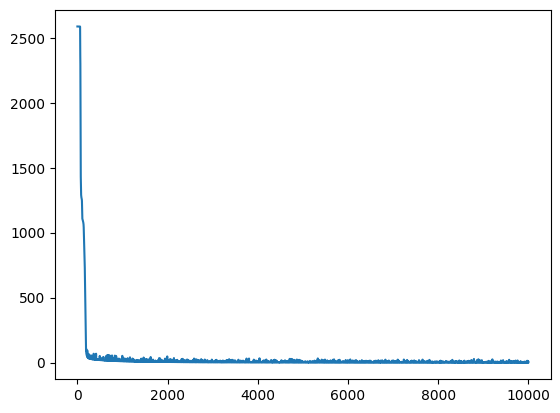

In [28]:
import matplotlib.pyplot as plt

plt.clf()
x = range(0, len(loss_vector))
y = loss_vector
plt.plot(x, y) 

## Test

In [29]:
meshSize = 0.001
order = 1
#all the boundary conditions are homogenous dirichlet boundary conditions so we use just one marker for the border equal to 1
domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize } 
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)

discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] } 
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

# boundary points
x0_bc = strongs[0].reshape(-1,1)
x1_bc = strongs[1].reshape(-1,1)

# transform to tensor
x_0_bc_tensor = Variable(torch.from_numpy(x0_bc).float(), requires_grad=False)
x_1_bc_tensor = Variable(torch.from_numpy(x1_bc).float(), requires_grad=False)

# interior points
x0 = dofs[0].reshape(-1,1)
x1 = dofs[1].reshape(-1,1)

# transform to tensor
x_0_tensor = Variable(torch.from_numpy(x0).float(), requires_grad=True)
x_1_tensor = Variable(torch.from_numpy(x1).float(), requires_grad=True)

mu = [0.5, 0.1]
mu_0_tensor = torch.tensor(mu[0], dtype=torch.float32).expand(x_0_tensor.size(0), 1)
mu_1_tensor = torch.tensor(mu[1], dtype=torch.float32).expand(x_0_tensor.size(0), 1)

mu_0_bc_tensor = torch.tensor(mu[0], dtype=torch.float32).expand(x_0_bc_tensor.size(0), 1)
mu_1_bc_tensor = torch.tensor(mu[1], dtype=torch.float32).expand(x_0_bc_tensor.size(0), 1)

## Prediction

In [30]:
def predict_solution(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor, net):
    time_prediction = 0
    start_prediction = time.time()
    all_zeros = np.zeros((x_1_tensor.shape[0],1))
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False)
    u_pred = net(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor)
    
    u_x0 = torch.autograd.grad(u_pred.sum(), x_0_tensor, create_graph=True)[0] #derivative of u with respect to x_0
    u_x0x0 = torch.autograd.grad(u_x0.sum(), x_0_tensor, create_graph=True)[0] #second derivative of u with respect to x_0
    
    
    u_x1 = torch.autograd.grad(u_pred.sum(), x_1_tensor, create_graph=True)[0] #derivative of u with respect to x_1
    u_x1x1 = torch.autograd.grad(u_x1.sum(), x_1_tensor, create_graph=True)[0] #second derivative of u with respect to x_1
    
    u_xx = u_x0x0 + u_x1x1
    
    g = torch.Tensor(100.0 * np.sin(2 * np.pi * x_0_tensor.detach().numpy()) * np.cos(2 * np.pi * x_1_tensor.detach().numpy()))
    
    f_nolinear = mu_0_tensor / mu_1_tensor * (torch.exp(mu_1_tensor * u_pred)-1)
    
    pde = - u_xx + f_nolinear - g
    
    mse_f = mse_cost_function(pde, pt_all_zeros)
    time_prediction = time.time() - start_prediction

    return u_pred, time_prediction

In [31]:
# prediction of the solution
[u_pred, _] = predict_solution(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor, net) 
u_pred = u_pred.data.cpu().numpy().astype(np.float64)
u_pred = u_pred.reshape(-1)
u_strong = np.zeros(problemData['NumberStrongs'], order='F')

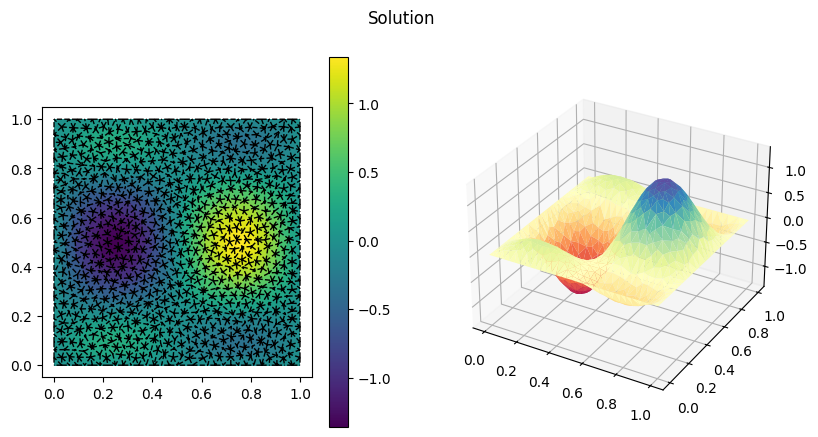

In [32]:
gedim.PlotSolution(mesh, dofs, strongs, u_pred, u_strong)

## Error and speed-up analysis

In [33]:
### compute error

abs_err = []
rel_err = []
abs_err_L2 = []
rel_err_L2 = []
testing_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(20, P.shape[0]))
tot_speed_up = []

print("Computing error and speedup analysis")

for mu in testing_set:
    [u_k, u_strong, time_FOM, time_assembling_FOM] = compute_FOM(mu, lib, problemData)
    mu_0_tensor = torch.tensor(mu[0], dtype=torch.float32).expand(x_0_tensor.size(0), 1)
    mu_1_tensor = torch.tensor(mu[1], dtype=torch.float32).expand(x_0_tensor.size(0), 1)

    num_prediction = 200
    time_pred = []
    for i in range(num_prediction):
        [u_predicted, time_prediction] = predict_solution(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor, net) 
        time_pred.append(time_prediction)
    
    av_time_prediction = sum(time_pred)/200
    
    u_predicted = u_predicted.data.cpu().numpy().astype(np.float64)
    u_predicted = u_predicted.reshape(-1)

    tot_speed_up.append(sum(time_assembling_FOM+time_FOM)/av_time_prediction)
    
    error_vector = u_k - u_predicted
    absolute_error_L2 = np.linalg.norm(error_vector,2)
    error_norm_squared_comp = np.transpose(error_vector) @ inner_product @ error_vector
    absolute_error = np.sqrt(np.abs(error_norm_squared_comp))
    abs_err.append(absolute_error)
    abs_err_L2.append(absolute_error_L2)

    relative_error_L2 = absolute_error_L2/np.linalg.norm(u_k,2)
    full_solution_norm_squared_component = np.transpose(u_k) @  inner_product @ u_k
    relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
    rel_err.append(relative_error)
    rel_err_L2.append(relative_error_L2)

Computing error and speedup analysis


In [34]:
print(f'Average relative error: {np.mean(rel_err)}')
print(f'Average absolute error: {np.mean(abs_err)}')

print(f'Average relative L2 error: {np.mean(rel_err_L2)}')
print(f'Average absolute L2 error: {np.mean(abs_err_L2)}')

print(f'Average PINN speed-up : {np.mean(tot_speed_up)}')

Average relative error: 0.03188013209191971
Average absolute error: 0.14615449512059092
Average relative L2 error: 0.015015466664439227
Average absolute L2 error: 0.21677312460268242
Average PINN speed-up : 434.1135278815652


# POD-NN

In the POD-NN strategy the projection stage is not performed and thus the speedup is guaranteed, yet having accurate solutions.
The POD-NN algorithm relies on a POD algorithm and on the training of a Feed-Forward Neural Network that predicts the entries of the reduced solution.

Let us define the Feed-Forward Neural Network.

In [24]:
import torch.nn.functional as F

mu_dim = P.shape[0]
basis_dim = N 
input_dim = mu_dim # equal to the dim of parameter space
output_dim = basis_dim # basis number chosen before
nodes = 30 # number of nodes inside

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, nodes) 
        self.fc2 = nn.Linear(nodes, nodes)
        self.fc3 = nn.Linear(nodes, nodes)
        self.fc4 = nn.Linear(nodes, nodes)
        self.fc5 = nn.Linear(nodes, output_dim) # 4 layers before the output
        self.tanh = nn.Tanh() #activation function
        # self.apply(self._init_weights)


    def forward(self, x):  ### Forward law ----> prediction
        x = self.tanh(self.fc1(x))   
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        x = self.fc5(x) #in the end we don't use tanh(x) but just the summation
        return x

In [25]:
seed_num = 31
torch.manual_seed(seed_num)
net = Net()
torch.set_default_dtype(torch.float32)

my_loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
epoch_max = 500000
epoch = 0
tol = 1e-5
loss = 1.

We need to prepare the outputs to train the NN. Indeed, our goal is to define 
$$
\boldsymbol \pi(\boldsymbol \mu) = \underline{u}_{\mathsf{rb}}^{NN}(\boldsymbol \mu),
$$
where the inputs are the parameters and the output is $\underline{u}_{\mathsf{rb}}$ such that
 $$
 \mathbb B \underline{u}_{\mathsf{rb}}(\boldsymbol \mu) = \mathbb P^{\boldsymbol \mu}u_{{\delta}}(\boldsymbol \mu), 
 $$
 where $\mathbb P^{\boldsymbol \mu} = \mathbb B \mathbb X_{N}^{-1} \mathbb B^T\mathbb X_{\delta}$ is the reduced vector related to the Galerkin projector, i.e. it gives the best approximation of $u_\delta$ in $V_N$ with respect to the inner-product defined by the matrix $\mathbb X_{\delta}$.

 Instead of computing the inverse of $\mathbb X_{N} = \mathbb B^T \mathbb X_{{\delta}} \mathbb B$ we solve 
 $$
 \mathbb B^T \mathbb X_{{\delta}} \mathbb B \underline{u}_{\mathsf {rb}}(\boldsymbol \mu) =
 \mathbb X_{N} \mathbb B \underline{u}_{\mathsf {rb}}(\boldsymbol \mu)
  \mathbb B^T \mathbb X_{{\delta}} u_{{\delta}}(\boldsymbol \mu)
 $$
 to find $u_{\mathsf{rb}}(\boldsymbol \mu)$ for each snapshot.

In this way we are taking the vector of the reduced solution related to the parameter $\boldsymbol \mu$ **without solving the reduced system**. This element is the closest element (the best choice) to $u_{\delta}$ in the norm of the problem.

In [26]:
### training set 
reduced_inner_product = np.transpose(basis_functions) @ inner_product @ basis_functions
x_train = torch.tensor(np.float32(training_set)) #the input is related to the training set that we have because the input are not the snapshots but the parameters
y_train = []

#given the snapshots and the basis matrix B, the pi operator and the loss, the target is to solve the system X_N  u_{rb}(\mu) = (B^T X_\mathcal{N} B) u_{rb}(\mu) = B^T X_\mathcal{N} u^\mathcal{N}(\mu)

for i in range(snapshot_matrix.shape[0]):
  
  snapshot_to_project = snapshot_matrix[i]
  
  projected_snapshot = np.linalg.solve(reduced_inner_product, np.transpose(basis_functions)@inner_product@snapshot_to_project)
  
  y_train.append(projected_snapshot) # we append it in the target (in the definition of the loss function)

y_train = np.float32(y_train)
y_train = torch.tensor(y_train)

Let us train the Neural Network.

In [27]:
loss_POD_NN = []
while loss >= tol and epoch < epoch_max:
  epoch = epoch + 1
  optimizer.zero_grad()
          
  ## compute output
  output = net(x_train)
  
          
  loss = my_loss(output, y_train)
  if epoch >= 20000:
    optimizer.param_groups[0]['lr'] = 0.0001 
  #compute the gradients
  loss.backward()
  # optimizer update
  optimizer.step() 
  if epoch % 200 == 199:
    loss_POD_NN.append(loss.item())
    print("epoch", epoch, 'loss', loss.item(), 'lr', optimizer.param_groups[0]['lr'] )

epoch 199 loss 173.98524475097656 lr 0.001
epoch 399 loss 107.62532806396484 lr 0.001
epoch 599 loss 72.9452133178711 lr 0.001
epoch 799 loss 52.31436538696289 lr 0.001
epoch 999 loss 38.062625885009766 lr 0.001
epoch 1199 loss 27.988506317138672 lr 0.001
epoch 1399 loss 21.075815200805664 lr 0.001
epoch 1599 loss 16.075542449951172 lr 0.001
epoch 1799 loss 12.308995246887207 lr 0.001
epoch 1999 loss 9.458015441894531 lr 0.001
epoch 2199 loss 7.265556812286377 lr 0.001
epoch 2399 loss 5.568233013153076 lr 0.001
epoch 2599 loss 4.295872211456299 lr 0.001
epoch 2799 loss 3.3248937129974365 lr 0.001
epoch 2999 loss 2.5853140354156494 lr 0.001
epoch 3199 loss 2.0121467113494873 lr 0.001
epoch 3399 loss 1.5683696269989014 lr 0.001
epoch 3599 loss 1.2313822507858276 lr 0.001
epoch 3799 loss 0.9710187911987305 lr 0.001
epoch 3999 loss 0.7724926471710205 lr 0.001
epoch 4199 loss 0.614316999912262 lr 0.001
epoch 4399 loss 0.4867359697818756 lr 0.001
epoch 4599 loss 0.3849458694458008 lr 0.001
e

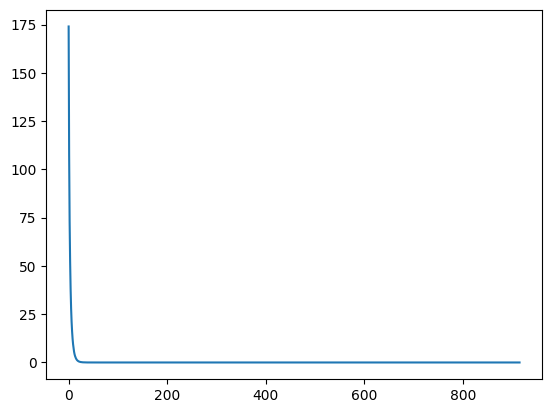

In [34]:
import matplotlib.pyplot as plt

plt.clf()
x = range(0, len(loss_POD_NN))
y = loss_POD_NN
plt.plot(x, y) 

Let us compute a specific instance of the problem ($\boldsymbol \pi (\boldsymbol \mu_{test}))$ and compare it with the full solution.

In [35]:
### compute the reduced solution

x_test = [[0.5, 0.1]] 
x_test = np.float32(x_test)
x_test = torch.tensor(x_test)

reduced_solution = np.asarray(net(x_test).detach().numpy())[0] #we transform the tensor in an array form

print(reduced_solution)

[ 14.221752 -12.263729  31.07795 ]


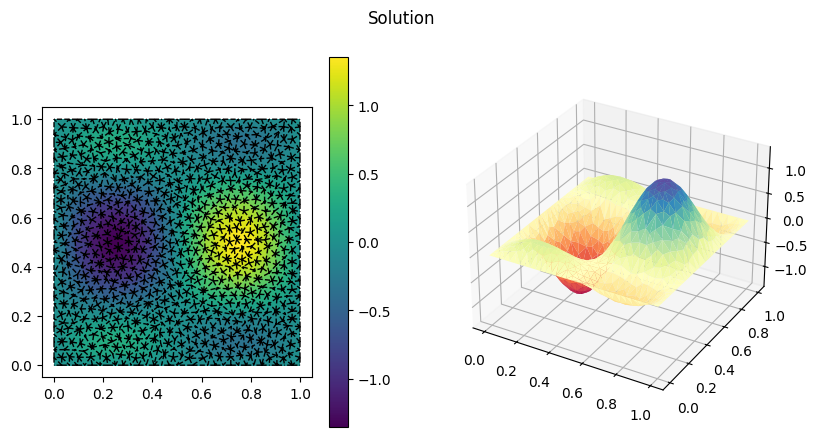

In [36]:
nn_proj_reduced_solution = basis_functions @ reduced_solution # we want to see the solution in the high fidelity setting
mu = x_test[0]

u_strong = np.zeros(problemData['NumberStrongs'], order='F') 

gedim.PlotSolution(mesh, dofs, strongs, nn_proj_reduced_solution, u_strong)

## Error and speed-up analysis

In [37]:
abs_err = []
rel_err = []
abs_err_L2 = []
rel_err_L2 = []
testing_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(20, P.shape[0]))
tot_speed_up = []

print("Computing error and speedup analysis")

for mu in testing_set:
    [u_k, u_strong, time_FOM, time_assembling_FOM] = compute_FOM(mu, lib, problemData)

    x_test = [[mu[0], mu[1]]] 
    x_test = np.float32(x_test)
    x_test = torch.tensor(x_test)

    start_rom = time.time()
    reduced_sol = np.asarray(net(x_test).detach().numpy())[0]
    nn_proj_reduced_sol = basis_functions @ reduced_sol
    time_POD_NN = time.time() - start_rom
    
    tot_speed_up.append(sum(time_assembling_FOM+time_FOM)/(time_POD_NN))
    
    error_vector = u_k - nn_proj_reduced_sol
    absolute_error_L2 = np.linalg.norm(error_vector,2)
    error_norm_squared_comp = np.transpose(error_vector) @ inner_product @ error_vector
    absolute_error = np.sqrt(np.abs(error_norm_squared_comp))
    abs_err.append(absolute_error)
    abs_err_L2.append(absolute_error_L2)

    relative_error_L2 = absolute_error_L2/np.linalg.norm(u_k,2)
    full_solution_norm_squared_component = np.transpose(u_k) @  inner_product @ u_k
    relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
    rel_err.append(relative_error)
    rel_err_L2.append(relative_error_L2)

Computing error and speedup analysis


In [38]:
print(f'Average relative error: {np.mean(rel_err)}')
print(f'Average absolute error: {np.mean(abs_err)}')

print(f'Average relative L2 error: {np.mean(rel_err_L2)}')
print(f'Average absolute L2 error: {np.mean(abs_err_L2)}')
print(f'Average tot_speed-up : {np.mean(tot_speed_up)}')

Average relative error: 0.0009187092820931202
Average absolute error: 0.004202266058490822
Average relative L2 error: 0.0009184549978420888
Average absolute L2 error: 0.013212681794108744
Average tot_speed-up : 4926.036521565295
